# Analysis of results of inference on Moran model: compare 2 conditions

In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.moran.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns

from lfimodels.moran.Moran import Moran
from lfimodels.moran.MoranStats import MoranStats
from delfi.utils.viz import samples_nd
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## model, prior, summary statistics

In [2]:
seed_p = 1
seed_m = 1
n_summary = 6

labels_params = ['Midpoint', 'Slope', 'High-to-high', 'Low-to-low', 'Baseline']

# different recordings

# original experiments
rec_WT_DMSO_exclude = ['WT_slice-'+str(i+1) for i in range(10,14)]
rec_Ts65Dn_DMSO_exclude = ['Ts65Dn_slice-'+str(i+1) for i in range(8,14)]
rec_WT = ['WT_slice-'+str(i+1) for i in range(14)]
rec_Ts65Dn = ['Ts65Dn_slice-'+str(i+1) for i in range(14)]
rec_WT = [rec for rec in rec_WT if rec not in rec_WT_DMSO_exclude]
rec_Ts65Dn = [rec for rec in rec_Ts65Dn if rec not in rec_Ts65Dn_DMSO_exclude]

# Bumetanide experiments
rec_Ts_DMSO_exclude = ['DMSO_slice-'+str(i) for i in [3,8,11,12,13,14,15,16,17,18]]
rec_Ts_Bume_exclude = ['BUME_slice-'+str(i) for i in [1,10,11,12,13,14,15,16]]
rec_Ts_DMSO = ['DMSO_slice-'+str(i+1) for i in range(19)]
rec_Ts_Bume = ['BUME_slice-'+str(i+1) for i in range(17)]
rec_Ts_DMSO = [rec for rec in rec_Ts_DMSO if rec not in rec_Ts_DMSO_exclude]
rec_Ts_Bume = [rec for rec in rec_Ts_Bume if rec not in rec_Ts_Bume_exclude]

rec_labels = ['WT','WT_DMSO','Ts65Dn','Ts_DMSO1','Ts_DMSO2','Ts_Bume']
all_recs = [rec_WT,rec_WT_DMSO_exclude,rec_Ts65Dn,rec_Ts65Dn_DMSO_exclude,rec_Ts_DMSO,rec_Ts_Bume]

# choose recordings to compare
condition1 = 0
condition2 = 1

rec_label_condition1 = rec_labels[condition1]
rec_label_condition2 = rec_labels[condition2]
rec_condition1 = all_recs[condition1]
rec_condition2 = all_recs[condition2]

num_rec_condition1 = len(rec_condition1)
num_rec_condition2 = len(rec_condition2)

m = Moran(seed=seed_m)
p = utils.prior(seed=seed_p)
s = MoranStats(n_summary=n_summary)

prior_min = p.lower
prior_max = p.upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

## load results

In [3]:
posterior_condition1_ls = []
# for rec in rec_condition1_changed:
for rec in rec_condition1:
    filename = './results/posterior_single_round_{rec}.pkl'.format(rec=rec)
    _, _, posterior = io.load_pkl(filename)
    posterior_condition1_ls.append(posterior)
    
posterior_condition2_ls = []
# for rec in rec_condition2_changed:
for rec in rec_condition2:
    filename = './results/posterior_single_round_{rec}.pkl'.format(rec=rec)
    _, _, posterior = io.load_pkl(filename)
    posterior_condition2_ls.append(posterior)

## sample from posteriors

In [4]:
# sample from posterior
num_samp = 100000

posterior_samples_condition1_ls = []
num_samp_condition1 = np.zeros(num_rec_condition1).astype('int')
for i in range(num_rec_condition1):
    posterior_samples = posterior_condition1_ls[i][0].gen(num_samp)

    # reject samples for which prior is zero
    ind = (posterior_samples > prior_min) & (posterior_samples < prior_max)
#     ind = 0*posterior_samples+1
    posterior_samples = posterior_samples[np.prod(ind,axis=1)==1]
    
    num_samp_condition1[i] = int(len(posterior_samples[:,0]))
    
    posterior_samples_condition1_ls.append(posterior_samples)
    print(i)
    
posterior_samples_condition2_ls = []
num_samp_condition2 = np.zeros(num_rec_condition2).astype('int')
for i in range(num_rec_condition2):
    posterior_samples = posterior_condition2_ls[i][0].gen(num_samp)

    # reject samples for which prior is zero
    ind = (posterior_samples > prior_min) & (posterior_samples < prior_max)
#     ind = 0*posterior_samples+1
    posterior_samples = posterior_samples[np.prod(ind,axis=1)==1]
    
    num_samp_condition2[i] = int(len(posterior_samples[:,0]))
    
    posterior_samples_condition2_ls.append(posterior_samples)
    print(i)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


0
1
2
3
4
5
6
7
8
9
0
1
2
3


## exclude from analysis posteriors without samples inside prior bounds

In [5]:
num_samp_condition1

array([33823, 32175, 26077, 50297,  3537,   865, 72703, 12061, 40970,
       51171])

In [6]:
num_samp_condition2

array([71710, 49744, 57748, 35396])

In [7]:
min_num = 10000
posterior_samples_condition1_subset_ls = [posterior_samples_condition1_ls[i] for i in range(num_rec_condition1) if num_samp_condition1[i]>min_num]
posterior_samples_condition1_subset_mat = np.asarray(posterior_samples_condition1_subset_ls)

posterior_samples_condition2_subset_ls =\
[posterior_samples_condition2_ls[i] for i in range(num_rec_condition2) if num_samp_condition2[i]>min_num]
posterior_samples_condition2_subset_mat = np.asarray(posterior_samples_condition2_subset_ls)

rec_condition1_subset = [rec_condition1[i] for i in range(num_rec_condition1) if num_samp_condition1[i]>min_num]
rec_condition2_subset = [rec_condition2[i] for i in range(num_rec_condition2) if num_samp_condition2[i]>min_num]

posterior_condition1_subset_ls = [posterior_condition1_ls[i] for i in range(num_rec_condition1) if num_samp_condition1[i]>min_num]
posterior_condition2_subset_ls = [posterior_condition2_ls[i] for i in range(num_rec_condition2) if num_samp_condition2[i]>min_num]

num_rec_condition1_subset = len(rec_condition1_subset)
num_rec_condition2_subset = len(rec_condition2_subset)

In [8]:
num_rec_condition1_subset

8

In [9]:
num_rec_condition2_subset

4

## plot posteriors

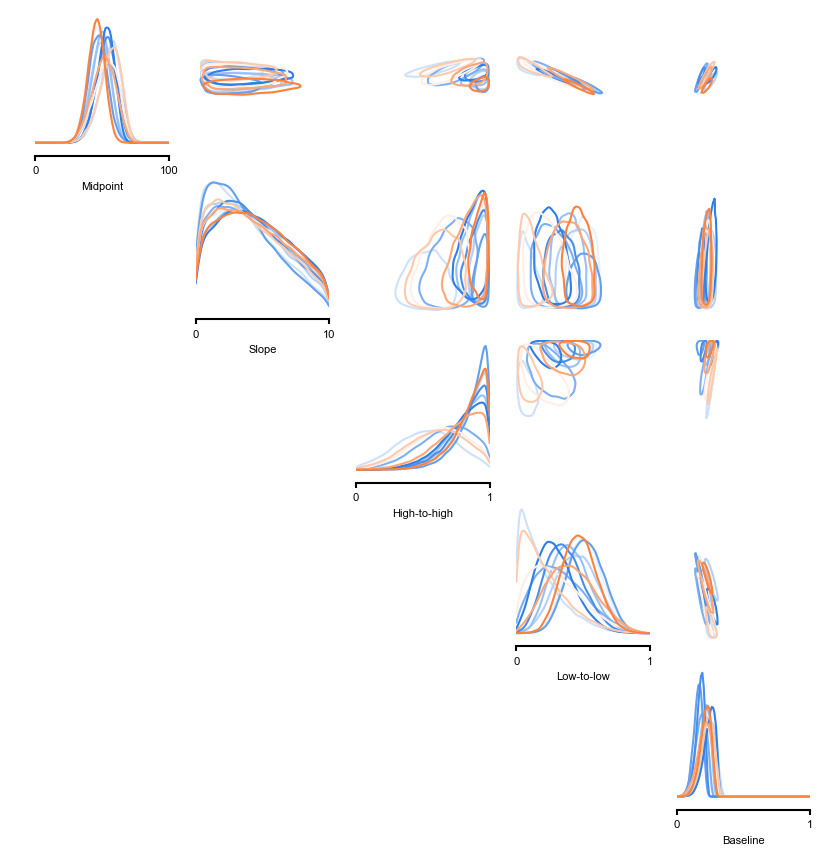

In [10]:
# colors condition1 and condition2
col_condition1 = (46/255,127/255,232/255)
col_condition2 = (252/255,130/255,62/255)
col_condition1 = sns.light_palette(col_condition1, n_colors=num_rec_condition1_subset).as_hex()
col_condition2 = sns.light_palette(col_condition2, n_colors=num_rec_condition2_subset).as_hex()
col_contrs = col_condition1+col_condition2

with PdfPages('Moran_all_posteriors_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:
    fig, axes = samples_nd(posterior_samples_condition1_subset_ls+posterior_samples_condition2_subset_ls, 
                           samples_colors=col_contrs,
                           title='',
                           upper='contour', 
                           diag='kde',
                           limits=prior_lims,
                           ticks=prior_lims,
                           labels=labels_params,
                           fig_size=(10,10),
                           kde_offdiag={'bins': 100},
                           contour_offdiag={'levels': [0.68]});
    
    pdf.savefig()
#     plt.close()
    plt.show()

## basic statistics: means and standard deviations for each posterior

In [11]:
mn_posterior_condition1_ls = [np.mean(posterior_samples_condition1_subset_mat[i],0) for i in range(num_rec_condition1_subset)]
std_posterior_condition1_ls = [np.std(posterior_samples_condition1_subset_mat[i],0) for i in range(num_rec_condition1_subset)]

mn_posterior_condition2_ls = [np.mean(posterior_samples_condition2_subset_mat[i],0) for i in range(num_rec_condition2_subset)]
std_posterior_condition2_ls = [np.std(posterior_samples_condition2_subset_mat[i],0) for i in range(num_rec_condition2_subset)]


mn_posterior_condition1_mat = np.asarray(mn_posterior_condition1_ls)
std_posterior_condition1_mat = np.asarray(std_posterior_condition1_ls)

mn_posterior_condition2_mat = np.asarray(mn_posterior_condition2_ls)
std_posterior_condition2_mat = np.asarray(std_posterior_condition2_ls)

### plotting

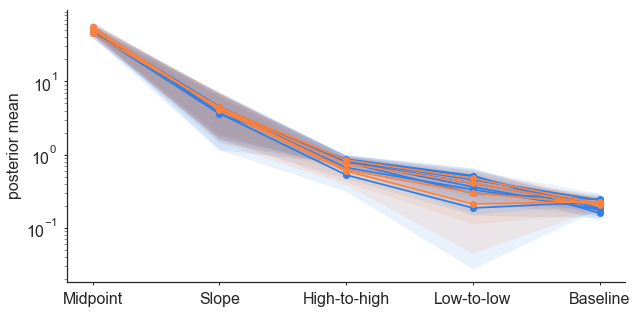

In [12]:
with PdfPages('Moran_all_means_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:
    fig = plt.figure(figsize=(10,5))

    num_params = 5
    xx = np.linspace(0,num_params-1,num_params)

    plt.semilogy(mn_posterior_condition1_mat.T,'o-',color=col_condition1[-1])
    plt.semilogy(mn_posterior_condition2_mat.T,'o-',color=col_condition2[-1])
    plt.ylabel('posterior mean')
    # plt.locator_params(axis='y', numticks=4)

    ax = plt.gca()
    for i in range(num_rec_condition1_subset):
        ax.fill_between(xx,
                        mn_posterior_condition1_mat[i,:]-std_posterior_condition1_mat[i,:],
                        mn_posterior_condition1_mat[i,:]+std_posterior_condition1_mat[i,:],
                        facecolor=col_condition1[-1], alpha=0.1)
    for i in range(num_rec_condition2_subset):
        ax.fill_between(xx,
                        mn_posterior_condition2_mat[i,:]-std_posterior_condition2_mat[i,:],
                        mn_posterior_condition2_mat[i,:]+std_posterior_condition2_mat[i,:],
                        facecolor=col_condition2[-1], alpha=0.1)
    ax.set_xticks(xx)
    ax.set_xticklabels(labels_params);    
    
    pdf.savefig()
#     plt.close()
    plt.show()

## active subspaces: main directions of variation for each posterior

In [13]:
from ActiveSubspace import ActiveSubspace

In [14]:
num_rec_condition1_subset

8

In [15]:
eig_val_condition1 = np.zeros((num_rec_condition1_subset,num_params))
eig_vec_condition1 = np.zeros((num_params,num_params,num_rec_condition1_subset))
for i in range(num_rec_condition1_subset):
    actSub_condition1 = ActiveSubspace(posterior_condition1_subset_ls[i][0],
                               num_params, data=posterior_samples_condition1_subset_mat[i])
    actSub_condition1.findActiveDimensions()
    actSub_condition1.buildProjectionMatrix()
    eig_val_condition1[i,:] = actSub_condition1.eigenvalues
    eig_vec_condition1[:,:,i] = actSub_condition1.eigenvectors

eig_val_condition2 = np.zeros((num_rec_condition2_subset,num_params))
eig_vec_condition2 = np.zeros((num_params,num_params,num_rec_condition2_subset))
for i in range(num_rec_condition2_subset):
    actSub_condition2 = ActiveSubspace(posterior_condition2_subset_ls[i][0],
                                   num_params, data=posterior_samples_condition2_subset_mat[i])
    actSub_condition2.findActiveDimensions()
    actSub_condition2.buildProjectionMatrix()
    eig_val_condition2[i,:] = actSub_condition2.eigenvalues
    eig_vec_condition2[:,:,i] = actSub_condition2.eigenvectors

### eigenvalues

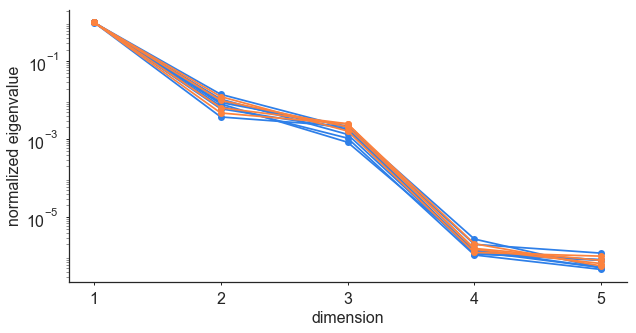

In [16]:
with PdfPages('Moran_ActiveSubspaces_eigenval_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:

    fig = plt.figure(figsize=(10,5))

    plt.semilogy(np.arange(1,1+num_params), eig_val_condition1.T/np.sum(eig_val_condition1,1),'o-',color=col_condition1[-1])
    plt.plot(np.arange(1,1+num_params), eig_val_condition2.T/np.sum(eig_val_condition2,1),'o-',color=col_condition2[-1])
    plt.xlabel('dimension')
    plt.ylabel('normalized eigenvalue')
    plt.locator_params(axis='y', numticks=4)
    ax = plt.gca()
    ax.set_xticks(np.arange(1,1+num_params));
    
    pdf.savefig()
#     plt.close()
    plt.show()

### active subspaces

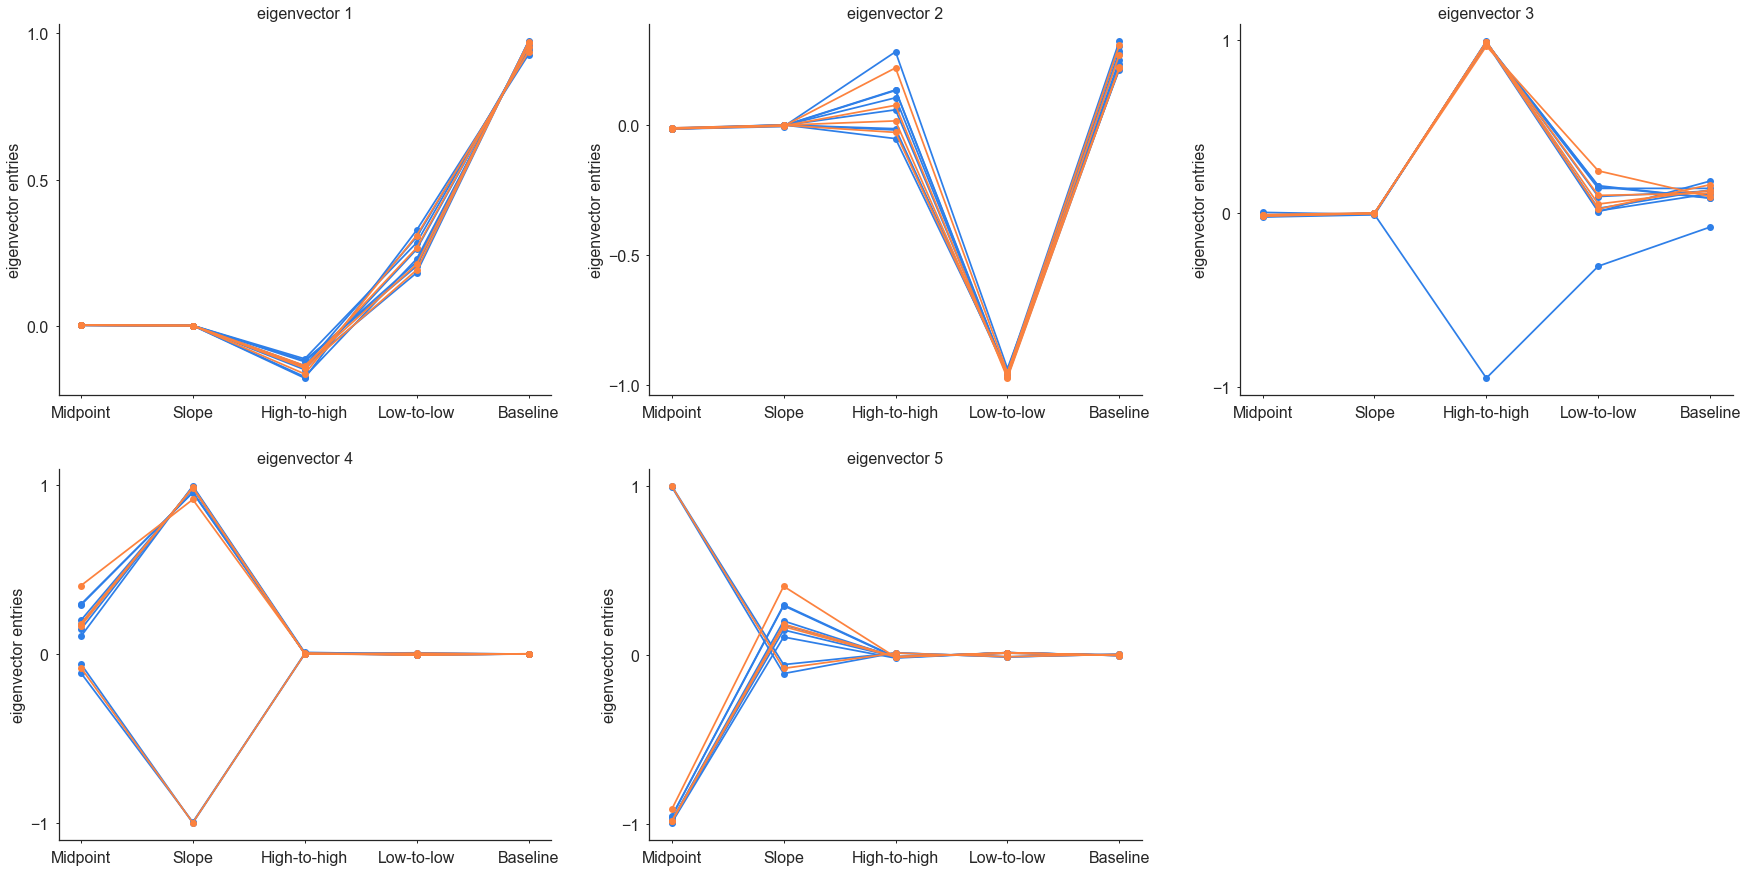

In [17]:
with PdfPages('Moran_ActiveSubspaces_eigenvec_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:

    fig = plt.figure(figsize=(30,15))

    xx = np.linspace(0,num_params-1,num_params)

    for i in range(num_rec_condition1_subset):
        for j in range(5):
            plt.subplot(2,3,j+1)
            vector = eig_vec_condition1[j,:,i]
            plt.plot(xx, vector,'o-',color=col_condition1[-1])

    for i in range(num_rec_condition2_subset):
        for j in range(5):
            plt.subplot(2,3,j+1)
            vector = eig_vec_condition2[j,:,i]
            plt.plot(xx, vector,'o-',color=col_condition2[-1])

            if i==0:
                plt.locator_params(axis='y', nbins=4)
                plt.ylabel('eigenvector entries')
                plt.title('eigenvector '+str(j+1))
                ax = plt.gca()
                ax.set_xticks(xx)
                ax.set_xticklabels(labels_params);
    
    
    pdf.savefig()
#     plt.close()
    plt.show()

## logistic regression to classify samples from posteriors of the 2 conditions

In [18]:
# force to have same number of recordings in the 2 conditions
min_num_subset = np.minimum(num_rec_condition1_subset,num_rec_condition2_subset)

In [19]:
min_num_subset

4

In [20]:
posterior_samples_condition1_subset_mat2 = np.zeros((min_num*min_num_subset,num_params))
posterior_samples_condition2_subset_mat2 = np.zeros((min_num*min_num_subset,num_params))
posterior_samples_condition1_subset_test = []
posterior_samples_condition2_subset_test = []
for i in range(min_num_subset):
    posterior_samples_condition1_subset_mat2[i*min_num:(i+1)*min_num,:] = posterior_samples_condition1_subset_mat[i][0:min_num,:]
    posterior_samples_condition1_subset_test.append(posterior_samples_condition1_subset_mat[i][min_num:2*min_num,:])
    
for i in range(min_num_subset):
    posterior_samples_condition2_subset_mat2[i*min_num:(i+1)*min_num,:] = posterior_samples_condition2_subset_mat[i][0:min_num,:]
    posterior_samples_condition2_subset_test.append(posterior_samples_condition2_subset_mat[i][min_num:2*min_num,:])
    
posterior_samples_condition1_subset_test2 = np.vstack(posterior_samples_condition1_subset_test)
posterior_samples_condition2_subset_test2 = np.vstack(posterior_samples_condition2_subset_test)

In [21]:
X = np.concatenate((posterior_samples_condition1_subset_mat2,posterior_samples_condition2_subset_mat2))
y = np.concatenate((np.ones(min_num*min_num_subset),2*np.ones(min_num*min_num_subset)))
X_test = np.concatenate((posterior_samples_condition1_subset_test2,posterior_samples_condition2_subset_test2))
y_test = np.concatenate((np.ones(len(posterior_samples_condition1_subset_test2)),
                         2*np.ones(len(posterior_samples_condition2_subset_test2))))

clf = LogisticRegression(random_state=0).fit(X, y)

pred_y_test = clf.predict(X_test)
# pred_probs = clf.predict_proba(X_test)

## accuracy for logistic regression with different parameters

### (1) logistic regression with all parameters or a single parameter

In [22]:
conf_mat_all = confusion_matrix(y_test, pred_y_test)
conf_mat_all_total = np.sum(conf_mat_all)
accuracy_all = (conf_mat_all[0,0]+conf_mat_all[1,1])/conf_mat_all_total

accuracy_1param = np.zeros(num_params)
for k in range(num_params):
    clf_1param = LogisticRegression(random_state=0).fit(X[:,k].reshape(-1,1), y)
    pred_y_test_1param = clf_1param.predict(X_test[:,k].reshape(-1,1))

    conf_mat_1param = confusion_matrix(y_test, pred_y_test_1param)
    total_1param = np.sum(conf_mat_1param)

    accuracy_1param[k] = (conf_mat_1param[0,0]+conf_mat_1param[1,1])/total_1param

accuracy_all_and_1param = np.concatenate((np.array([accuracy_all]),accuracy_1param))
labels_all_and_params = np.asarray(['All']+labels_params)
sort_params = np.argsort(accuracy_all_and_1param)[::-1]

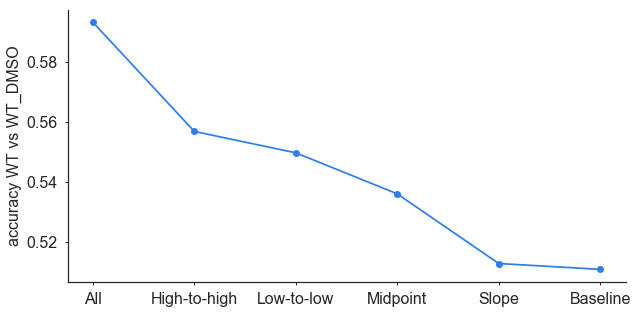

In [23]:
with PdfPages('Moran_accuracy_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:
    fig = plt.figure(figsize=(10,5))
    xx = np.linspace(1,num_params+1,num_params+1)
    plt.plot(xx,accuracy_all_and_1param[sort_params],'o-',color=col_condition1[-1])
    plt.ylabel('accuracy '+rec_label_condition1+' vs '+rec_label_condition2)
    ax = plt.gca()
    ax.set_xticks(xx)
    ax.set_xticklabels(labels_all_and_params[sort_params]);

    pdf.savefig()
#     plt.close()
    plt.show()

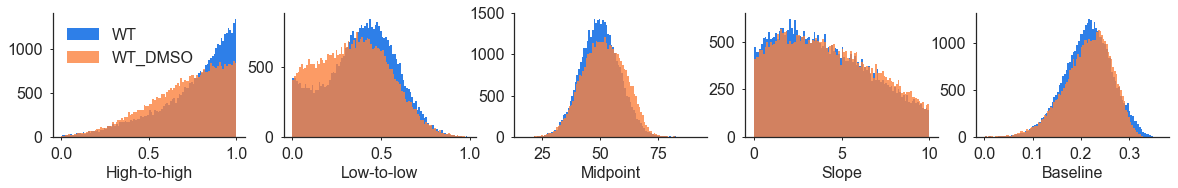

In [24]:
fig = plt.figure(figsize=(20,5))
i=1
for k in sort_params[1:]-1:
    plt.subplot(2,5,i)
    plt.hist(X[y==1,k],color=col_condition1[-1],label=rec_label_condition1,bins=100)
    plt.hist(X[y==2,k],color=col_condition2[-1],alpha=0.8,label=rec_label_condition2,bins=100)
    plt.xlabel(labels_params[k])
    if i==1:
        plt.legend()
    i+=1

### (1a) logistic regression with observed summary statistics

In [25]:
obs_stats_condition1_ls = []
for rec in rec_condition1_subset:
    obs = utils.LTP_obs_data(rec=rec)
    obs_stats = utils.LTP_obs_stats(rec=rec)
    obs_stats_condition1_ls.append(obs_stats[0])
obs_stats_condition1_mat = np.asarray(obs_stats_condition1_ls)
    
obs_stats_condition2_ls = []
for rec in rec_condition2_subset:
    obs = utils.LTP_obs_data(rec=rec)
    obs_stats = utils.LTP_obs_stats(rec=rec)
    obs_stats_condition2_ls.append(obs_stats[0])
obs_stats_condition2_mat = np.asarray(obs_stats_condition2_ls)


X_obs = np.concatenate((obs_stats_condition1_mat,obs_stats_condition2_mat))
y_obs = np.concatenate((np.ones(len(rec_condition1_subset)),2*np.ones(len(rec_condition2_subset))))

clf_obs = LogisticRegression(random_state=0).fit(X_obs, y_obs)

pred_y_obs = clf_obs.predict(X_obs)


conf_mat_obs = confusion_matrix(y_obs, pred_y_obs)
conf_mat_obs_total = np.sum(conf_mat_obs)
accuracy_obs = (conf_mat_obs[0,0]+conf_mat_obs[1,1])/conf_mat_obs_total

accuracy_obs

0.6666666666666666

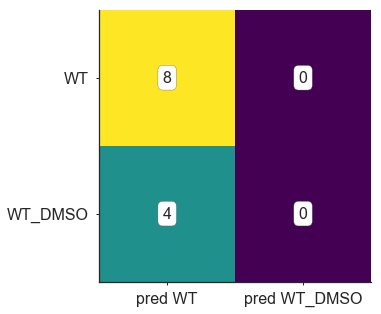

In [26]:
fig = plt.figure(figsize=(10,5))
plt.imshow(conf_mat_obs, cmap='viridis')

ax = plt.gca()
for (i, j), z in np.ndenumerate(conf_mat_obs):
    ax.text(j, i, str(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['pred '+rec_label_condition1,'pred '+rec_label_condition2])
ax.set_yticklabels([rec_label_condition1,rec_label_condition2]);

### (2) analysis per recording: all 1st conditions vs one 2nd condition

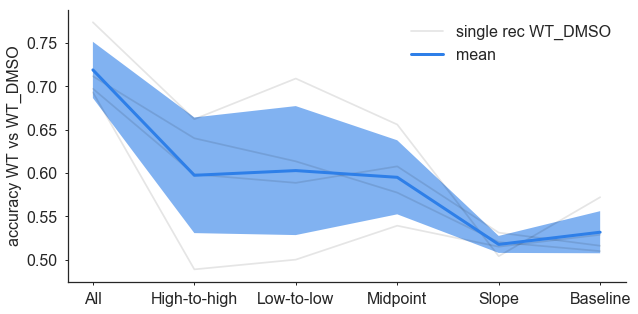

In [27]:
# subsample all condition1 posteriors, to get same or almost same number of samples as for one condition2 posterior
num_samples_all = len(posterior_samples_condition1_subset_mat2)
ind_condition1_samples_all = np.random.choice(num_samples_all, min_num, replace=False)
condition1_samples_all = posterior_samples_condition1_subset_mat2[ind_condition1_samples_all,:]

num_samples_all_test = len(posterior_samples_condition1_subset_test2)
ind_condition1_samples_all_test = np.random.choice(num_samples_all_test, min_num, replace=False)
condition1_samples_all_test = posterior_samples_condition1_subset_mat2[ind_condition1_samples_all_test,:]

xx = np.linspace(1,num_params+1,num_params+1)

# logistic regression all condition1 vs condition2
accuracy_all_and_1param_rec = np.zeros((min_num_subset,num_params+1))
# for i in range(num_rec_condition2_subset):
for i in range(min_num_subset):
    X_allcondition1_1Ts = np.concatenate((condition1_samples_all,posterior_samples_condition2_subset_mat[i][0:min_num,:]))
    y_allcondition1_1Ts = np.concatenate((np.ones(min_num),2*np.ones(min_num)))
    X_allcondition1_1Ts_test = np.concatenate((condition1_samples_all_test,posterior_samples_condition2_subset_test[i]))
    y_allcondition1_1Ts_test = np.concatenate((np.ones(len(condition1_samples_all_test)),
                             2*np.ones(len(posterior_samples_condition2_subset_test[i]))))

    clf = LogisticRegression(random_state=0).fit(X_allcondition1_1Ts, y_allcondition1_1Ts)
    pred_y_allcondition1_1Ts_test = clf.predict(X_allcondition1_1Ts_test)
    
    conf_mat_all = confusion_matrix(y_allcondition1_1Ts_test, pred_y_allcondition1_1Ts_test)
    conf_mat_all_total = np.sum(conf_mat_all)
    accuracy_all = (conf_mat_all[0,0]+conf_mat_all[1,1])/conf_mat_all_total

    # accuracy for logistic regression with different parameters
    accuracy_1param = np.zeros(num_params)
    for k in range(num_params):
        clf_1param = LogisticRegression(random_state=0).fit(X_allcondition1_1Ts[:,k].reshape(-1,1), y_allcondition1_1Ts)
        pred_y_test_1param = clf_1param.predict(X_allcondition1_1Ts_test[:,k].reshape(-1,1))

        conf_mat_1param = confusion_matrix(y_allcondition1_1Ts_test, pred_y_test_1param)
        total_1param = np.sum(conf_mat_1param)

        accuracy_1param[k] = (conf_mat_1param[0,0]+conf_mat_1param[1,1])/total_1param

    accuracy_all_and_1param_rec[i,:] = np.concatenate((np.array([accuracy_all]),accuracy_1param))
    
    
# plotting
fig = plt.figure(figsize=(10,5))
mn_accuracy = np.mean(accuracy_all_and_1param_rec[:,sort_params],0)
std_accuracy = np.std(accuracy_all_and_1param_rec[:,sort_params],0)
plt.plot(xx,accuracy_all_and_1param_rec[:-1,sort_params].T,'k', alpha=0.1)
plt.plot(xx,accuracy_all_and_1param_rec[-1,sort_params],'k', alpha=0.1, label='single rec '+rec_label_condition2)
plt.plot(xx,mn_accuracy,color=col_condition1[-1],lw=3, label='mean')
ax = plt.gca()
ax.fill_between(xx,
                mn_accuracy-std_accuracy,
                mn_accuracy+std_accuracy,
                facecolor=col_condition1[-1], alpha=0.6)
plt.ylabel('accuracy '+rec_label_condition1+' vs '+rec_label_condition2)
ax = plt.gca()
ax.set_xticks(xx)
ax.set_xticklabels(labels_all_and_params[sort_params]);
plt.legend();

### (3) logistic regression with all parameters or pairs of parameters

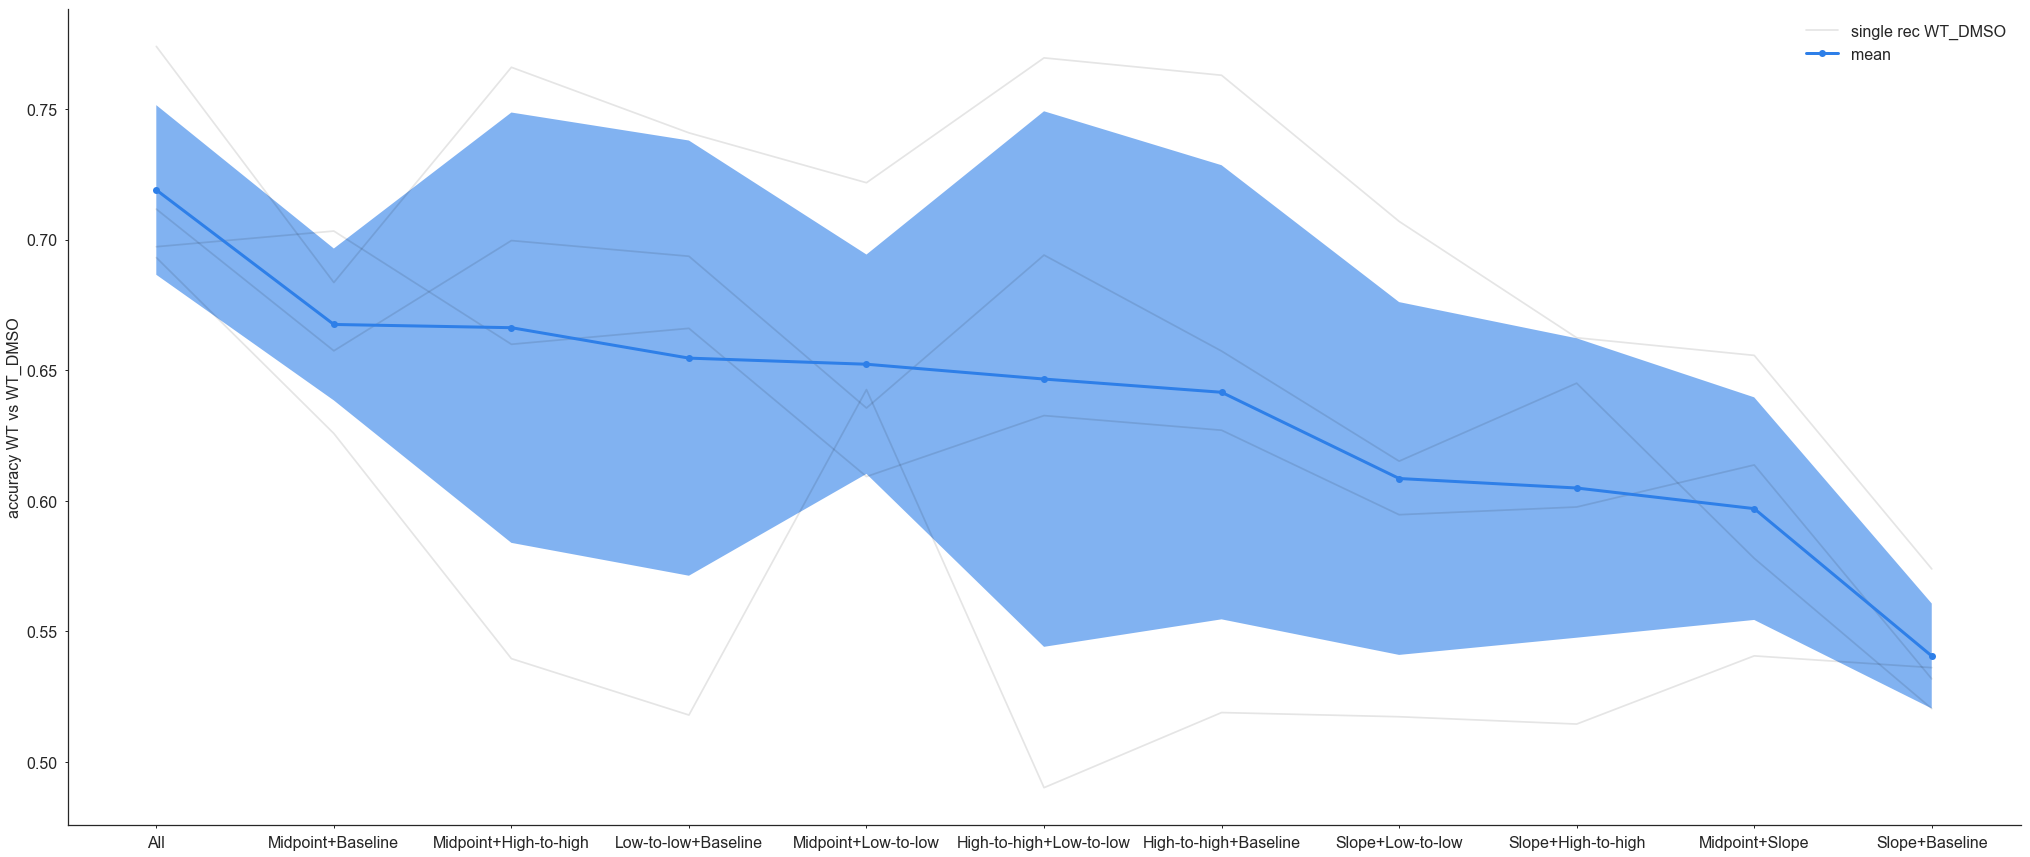

In [28]:
from itertools import combinations 

comb = list(combinations([0,1,2,3,4], 2))
num_comb = len(comb)

xx = np.linspace(1,num_comb+1,num_comb+1)

# logistic regression all 1st condition vs 2nd condition
accuracy_all_and_2param_rec = np.zeros((min_num_subset,num_comb+1))
# for i in range(num_rec_condition2_subset):
for i in range(min_num_subset):
    X_allcondition1_1Ts = np.concatenate((condition1_samples_all,posterior_samples_condition2_subset_mat[i][0:min_num,:]))
    y_allcondition1_1Ts = np.concatenate((np.ones(min_num),2*np.ones(min_num)))
    X_allcondition1_1Ts_test = np.concatenate((condition1_samples_all_test,posterior_samples_condition2_subset_test[i]))
    y_allcondition1_1Ts_test = np.concatenate((np.ones(len(condition1_samples_all_test)),
                             2*np.ones(len(posterior_samples_condition2_subset_test[i]))))

    clf = LogisticRegression(random_state=0).fit(X_allcondition1_1Ts, y_allcondition1_1Ts)
    pred_y_allcondition1_1Ts_test = clf.predict(X_allcondition1_1Ts_test)
    
    conf_mat_all = confusion_matrix(y_allcondition1_1Ts_test, pred_y_allcondition1_1Ts_test)
    conf_mat_all_total = np.sum(conf_mat_all)
    accuracy_all = (conf_mat_all[0,0]+conf_mat_all[1,1])/conf_mat_all_total

    # accuracy for logistic regression with different parameters
    accuracy_2param = np.zeros(num_comb)
    for k in range(num_comb):
        clf_2param = LogisticRegression(random_state=0).fit(X_allcondition1_1Ts[:,comb[k]], y_allcondition1_1Ts)
        pred_y_test_2param = clf_2param.predict(X_allcondition1_1Ts_test[:,comb[k]])

        conf_mat_2param = confusion_matrix(y_allcondition1_1Ts_test, pred_y_test_2param)
        total_2param = np.sum(conf_mat_2param)

        accuracy_2param[k] = (conf_mat_2param[0,0]+conf_mat_2param[1,1])/total_2param

    accuracy_all_and_2param_rec[i,:] = np.concatenate((np.array([accuracy_all]),accuracy_2param))
    
    
labels_2params = [labels_params[kk[0]]+'+'+labels_params[kk[1]] for kk in comb]
labels_all_and_2params = np.asarray(['All']+labels_2params)

mn_accuracy = np.mean(accuracy_all_and_2param_rec,0)
std_accuracy = np.std(accuracy_all_and_2param_rec,0)
sort_mn_accuracy = np.argsort(mn_accuracy)[::-1]

fig = plt.figure(figsize=(35,15))
plt.plot(xx,accuracy_all_and_2param_rec[:-1,sort_mn_accuracy].T,'k', alpha=0.1)
plt.plot(xx,accuracy_all_and_2param_rec[-1,sort_mn_accuracy],'k', alpha=0.1, label='single rec '+rec_label_condition2)
plt.plot(xx,mn_accuracy[sort_mn_accuracy],'-o',color=col_condition1[-1],lw=3, label='mean')
ax = plt.gca()
ax.fill_between(xx,
                mn_accuracy[sort_mn_accuracy]-std_accuracy[sort_mn_accuracy],
                mn_accuracy[sort_mn_accuracy]+std_accuracy[sort_mn_accuracy],
                facecolor=col_condition1[-1], alpha=0.6)
plt.ylabel('accuracy '+rec_label_condition1+' vs '+rec_label_condition2)
ax = plt.gca()
ax.set_xticks(xx)
ax.set_xticklabels(labels_all_and_2params[sort_mn_accuracy]);
plt.legend();

## some simulations

### pick the 3 samples with highest probability under each posterior

In [29]:
num_samp_subset = 3
num_params = len(labels_params)

posterior_samples_condition1_3sets = np.zeros((num_samp_subset,num_params,min_num_subset))
j=0
for i in range(num_rec_condition1):
    if num_samp_condition1[i]>min_num and j<min_num_subset:
        ind_hi_prob_snpe = np.argsort(posterior_condition1_ls[i][0].eval(posterior_samples_condition1_ls[i]),axis=0)[::-1]
        posterior_samples_condition1_3sets[:,:,j] = posterior_samples_condition1_ls[i][ind_hi_prob_snpe[0:num_samp_subset],:]
        j+=1

posterior_samples_condition2_3sets = np.zeros((num_samp_subset,num_params,min_num_subset))
j=0
for i in range(num_rec_condition2):
    if num_samp_condition2[i]>min_num and j<min_num_subset:
        ind_hi_prob_snpe = np.argsort(posterior_condition2_ls[i][0].eval(posterior_samples_condition2_ls[i]),axis=0)[::-1]
        posterior_samples_condition2_3sets[:,:,j] = posterior_samples_condition2_ls[i][ind_hi_prob_snpe[0:num_samp_subset],:]
        j+=1

### simulate parameter sets with highest probability

0
1
2
3


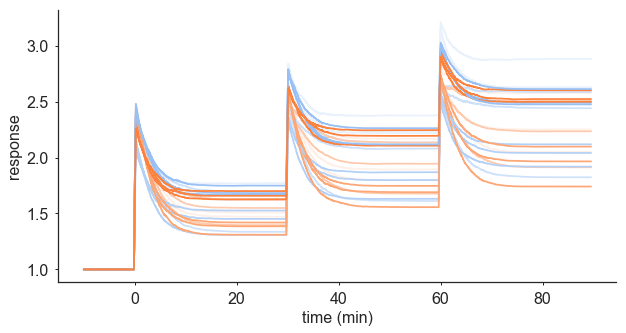

In [30]:
from lfimodels.moran.moranFunctions_v3 import run_sequential_ltp

obs = utils.LTP_obs_data(rec=rec_condition1[0])
t = obs['time']

fig = plt.figure(figsize=(10,5))

for k in range(min_num_subset):
    print(k)
    # simulate and plot samples
    for i in range(num_samp_subset):

        # parameters not fitted. Some with variability
        num_synapse = np.random.randint(900,1100)
        num_receptors = np.random.randint(90,110)
        param_fixed = [100, num_synapse, num_receptors, 1.0] #time_plast, num_synapse, num_receptors, gifit

        # numerical simulation
        simulation_condition1  = run_sequential_ltp(param_fixed, list(posterior_samples_condition1_3sets[i,:,k]))
        response_condition1 = simulation_condition1['wholetraj']/simulation_condition1['wholetraj'][0]
        simulation_condition2  = run_sequential_ltp(param_fixed, list(posterior_samples_condition2_3sets[i,:,k]))
        response_condition2 = simulation_condition2['wholetraj']/simulation_condition2['wholetraj'][0]
        
        
        # plot numerical simulations
#         plt.subplot(4,5,k+1)
        t_sim_condition1 = np.linspace(t[0],t[-1],len(response_condition1))
        t_sim_condition2 = np.linspace(t[0],t[-1],len(response_condition2))
        plt.plot(t_sim_condition1,response_condition1,col_condition1[k])
        plt.plot(t_sim_condition2,response_condition2,col_condition2[k])

        if i==num_samp_subset-1:
            plt.xlabel('time (min)')
            plt.ylabel('response')

#     ax = plt.gca()
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right');